In [1]:
%run ../setup.py

In [45]:
def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all(quality_bitmask="hardest")
    
    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())
    lc = lc.remove_outliers()

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time, magnitude

In [46]:
t, y = get_lightcurve('KIC 6780873', mission='Kepler')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c41472198>,
      dtype=object)

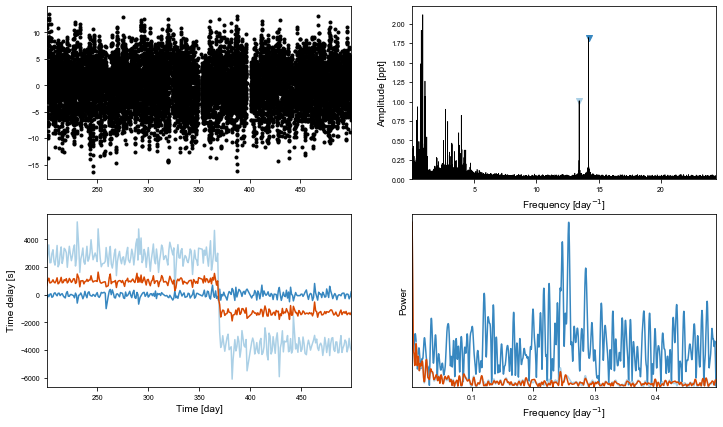

In [88]:
# t, y = np.loadtxt('../data/6780873_lc.txt', usecols=(0,1)).T
tmin, tmax = 0,50000
mask = (tmin < t)  & (t < tmax)
t = t[mask]
y = y[mask]
ms = Maelstrom(t, y, max_peaks=2, fmin=5, fmax=24)
ms.first_look(segment_size=1)

In [89]:
period_guess = 9.158
a_guess = 17.23

time, flux = ms.time, ms.flux
freq = ms.freq
weights = ms.get_weights(norm=False)

In [90]:
time, mag = ms.time, ms.flux

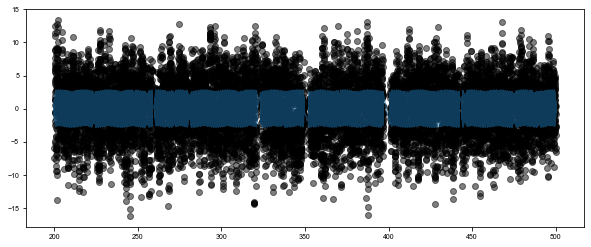

In [91]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(period_guess), sd=1.0,
                                      testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(a_guess), sd=5,
                                            testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=-1.03171101)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.01)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])
    
#     W_hat_cos = pm.Normal("W_hat_cos", mu=0.0, sd=0.01, shape=len(freq))
#     W_hat_sin = pm.Normal("W_hat_sin", mu=0.0, sd=0.01, shape=len(freq))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos[:, None])
#     model_tensor += tt.dot(tt.sin(arg), W_hat_sin[:, None])
#     lc_model = tt.squeeze(model_tensor)

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_mean_amp = np.log(ms.get_weights(norm=False))
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
#     logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/2.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
    pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=mag)

#     mag_sim = xo.eval_in_model(full_lc) + np.median(np.abs(np.diff(mag))) * np.random.randn(len(time))

#     pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())


    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model), alpha=0.5)
    plt.scatter(time,mag, c='black', alpha=0.5)

[phi_angle__, logs_lc, omega_angle__, eccen_interval__, mean, lognu, phase_angle__, logamp]


optimizing logp for variables: [mean]
5it [00:00,  5.83it/s, logp=-1.272545e+05] 
message: Optimization terminated successfully.
logp: -127254.50004964703 -> -127254.48503677886
optimizing logp for variables: [logs_lc]
11it [00:00, 107.91it/s, logp=-3.571474e+04]
message: Optimization terminated successfully.
logp: -127254.48503677886 -> -35714.7428674908
optimizing logp for variables: [logamp, phase]
102it [00:00, 143.66it/s, logp=-3.489012e+04]
message: Optimization terminated successfully.
logp: -35714.7428674908 -> -34890.12206862885
optimizing logp for variables: [omega, eccen]
22it [00:00, 111.74it/s, logp=-3.486658e+04]
message: Optimization terminated successfully.
logp: -34890.12206862885 -> -34866.57908128222
optimizing logp for variables: [phi]
16it [00:00, 110.63it/s, logp=-3.484612e+04]
message: Optimization terminated successfully.
logp: -34866.57908128222 -> -34846.12109218998
optimizing logp for variables: [lognu]
105it [00:00, 180.00it/s, logp=-3.484609e+04]
message: D

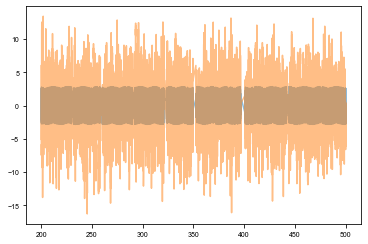

In [92]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [94]:
map_params

{'logP_interval__': array(-0.85276748),
 'phi_angle__': array([-3.97464388,  2.04992829]),
 'logs_lc': array(1.39706831),
 'logasini_interval__': array(0.16211953),
 'omega_angle__': array([-3.29833322, -3.02009899]),
 'eccen_interval__': array(0.03111732),
 'mean': array(0.00560098),
 'lognu': array([2.65237087, 2.5979631 ]),
 'phase_angle__': array([[ 1.83210942, -0.68207508],
        [ 4.07962928, -4.41981601]]),
 'logamp': array([0.60081158, 0.01933051]),
 'logP': array(2.29757154),
 'period': array(9.94998997),
 'phi': array(-1.09462712),
 'logasini': array(3.17239189),
 'asini': array(23.86449728),
 'omega': array(-2.31218759),
 'eccen': array(0.45700083),
 'nu': array([14.18763584, 13.4363416 ]),
 'phase': array([ 0.42209461, -2.98847846])}

In [ ]:
with model:
    trace = pm.sample(
        tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.9), start=map_params
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logamp, phase, lognu, mean, eccen, omega, logasini, logs_lc, phi, logP]
Sampling 2 chains:  27%|██▋       | 1081/4000 [27:24<1:55:50,  2.38s/draws]

In [76]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-7.785857e+00,2.745016e-09,2.744887e-10,-7.785857e+00,-7.785857e+00,1.116971,4.012608
mean,3.000000e-03,7.398266e-10,7.397961e-11,2.999999e-03,3.000001e-03,1.102184,4.265877
lognu__0,2.652357e+00,4.430280e-08,4.429875e-09,2.652357e+00,2.652357e+00,1.008303,14.711183
lognu__1,2.597965e+00,4.156686e-07,4.156519e-08,2.597965e+00,2.597966e+00,1.096308,4.383309
logamp__0,5.975652e-01,3.097360e-09,3.097008e-10,5.975652e-01,5.975652e-01,1.386564,2.455586
logamp__1,1.202627e-02,3.068354e-09,3.068173e-10,1.202627e-02,1.202627e-02,1.156845,3.524561
logpower,2.918875e+00,1.043512e-08,1.043477e-09,2.918875e+00,2.918875e+00,1.078142,4.828393
logP,2.214628e+00,2.891039e-09,2.890950e-10,2.214628e+00,2.214628e+00,1.073106,4.981350
period,9.158000e+00,2.647613e-08,2.647532e-09,9.158000e+00,9.158000e+00,1.073106,4.981350
phi,-1.524504e-08,1.685989e-08,1.685944e-09,-4.010184e-08,1.052836e-09,1.060958,5.427950


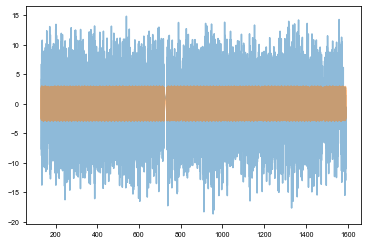

In [53]:
import pymc3 as pm
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as model:
    # Our orbital period prior
    period = pm.Normal("period", mu=period_guess, sd=0.1)
    # The phase of conjunction
    phi = xo.distributions.Angle("phi", testval=0.)
    # Our standard deviation
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
#     logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=5, testval=np.log(a_guess))
#     asini = pm.Deterministic("asini", pm.math.exp(logasini))
    asini = pm.Uniform('asini', lower=-30, upper=30, testval=20.)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=-1.5)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.05)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=5.0, testval=0.)
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", pm.math.exp(lognu))
    
    # Here, we generate an Orbit instance and pass in our priors. 
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu)
    
    # Orbit makes available a method which will calculate the theoretical light curve given the orbital parameters, times, and fluxes, following
    # equation 10 of the paper. 
    lc = orbit.get_lightcurve_model(time, flux) + mean
    
    # GP parameters
#     logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    
    # We pass this into our likelihood
    pm.Normal('obs', mu=lc, sd=tt.exp(logs_lc), observed=flux)
#     pm.Potential("obs", gp.log_likelihood(flux - lc))

# This is what our light curve looks like before any optimisation
with model:
    plt.plot(time, flux, alpha=0.5)
    plt.plot(time, xo.eval_in_model(lc), alpha=0.5)

In [54]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "asini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])

#     map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)

[period, phi_angle__, logs_lc, omega_angle__, eccen_interval__, mean, lognu]


optimizing logp for variables: [mean]
5it [00:00, 18.30it/s, logp=-5.243586e+05]
message: Optimization terminated successfully.
logp: -524358.8166606718 -> -524358.605582111
optimizing logp for variables: [logs_lc]
11it [00:00, 39.79it/s, logp=-1.671388e+05]
message: Optimization terminated successfully.
logp: -524358.605582111 -> -167138.8011324164
optimizing logp for variables: [phi]
30it [00:00, 38.31it/s, logp=-1.671150e+05]
message: Optimization terminated successfully.
logp: -167138.8011324164 -> -167114.97248822305
optimizing logp for variables: [lognu, mean, eccen, omega, logs_lc, phi, period]
164it [00:05, 30.04it/s, logp=-1.670928e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -167114.97248822305 -> -167092.8371686956
optimizing logp for variables: [asini]
56it [00:01, 34.82it/s, logp=-1.670926e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -167092.8371686956 -> -167092.5938431168
optimizing logp for variab

In [55]:
map_params

{'period': array(9.16158384),
 'phi_angle__': array([-3.68251191,  2.53753942]),
 'logs_lc': array(1.37696511),
 'asini_interval__': array(0.90338043),
 'omega_angle__': array([3.95091668, 2.0952943 ]),
 'eccen_interval__': array(-0.00217732),
 'mean': array(0.00265471),
 'lognu': array([2.6523713 , 2.59796287]),
 'phi': array(-0.96743796),
 'asini': array(12.69862113),
 'omega': array(1.08317923),
 'eccen': array(0.4495101),
 'nu': array([14.18764195, 13.43633855])}

In [33]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

with_gp = False

with pm.Model() as new_model:
    # Period
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1, shape=1, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    asini = pm.Normal('asini', mu=a_guess, sd=5, testval=a_guess)
    phi = xo.distributions.Angle('phi', testval=5.93)
    varpi = xo.distributions.Angle('varpi', testval=4.45)
    eccen = xo.distributions.UnitUniform("eccen", shape=1, testval=np.array([0.1]))
    
    mean = pm.Normal("mean", mu=np.mean(flux), sd=10.0, testval=np.mean(flux))
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(flux)))))
    sigma = pm.Deterministic('sigma', tt.exp(2*logs_lc))
    #     logs_lc = pm.HalfNormal("logs_lc",  sigma=0.25, testval=0.05)
    M = 2.0 * np.pi * (time) / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    tau = ((asini) / 86400) * psi[:, None]
    arg = 2. * np.pi * nu * (time[:, None] - tau)
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, flux))
    pm.Deterministic('w', w)
    lc_model = tt.dot(D, w)
    full_lc = lc_model - mean
    
    if with_gp:
        logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
        logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)

        pm.Potential("obs", gp.log_likelihood(flux - full_lc))
    else:
        pm.Normal('obs', mu=full_lc, 
                  sd=sigma, 
                  observed=flux)

In [34]:
with new_model:
    #map_params = xo.optimize(start=None, vars=[phi, varpi])
#     map_params = xo.optimize(start=None, vars=[logP, asini])
    map_params = xo.optimize(start=None, vars=[mean,logs_lc])
    map_params = xo.optimize(start=map_params, vars=[eccen, varpi])
#     map_params = xo.optimize(start=map_params, vars=[ecosw, esinw])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params)

    map_params = xo.optimize(start=map_params, vars=[logP])
    if with_gp:
        map_params = xo.optimize(start=map_params, vars=[logpower, logw0])

optimizing logp for variables: [logs_lc, mean]
82it [00:00, 112.05it/s, logp=-2.463342e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -24790.68213933984 -> -24633.419628067226
optimizing logp for variables: [varpi, eccen]
22it [00:00, 72.22it/s, logp=-2.461195e+04] 
message: Optimization terminated successfully.
logp: -24633.419628067226 -> -24611.949487073347
optimizing logp for variables: [phi]
20it [00:00, 61.14it/s, logp=-2.459149e+04] 
message: Optimization terminated successfully.
logp: -24611.949487073347 -> -24591.490878325923
optimizing logp for variables: [lognu]
12it [00:00, 51.68it/s, logp=-2.459149e+04] 
message: Optimization terminated successfully.
logp: -24591.490878325923 -> -24591.490778615123
INFO (theano.gof.compilelock): Refreshing lock /Users/danielhey/.theano/compiledir_Darwin-19.0.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
optimizing logp for variables: [lognu, logs_lc, mean, eccen, varpi, phi, asini, logP]
337it [00:02, 1

In [35]:
map_params

{'logP': array([2.19214946]),
 'asini': array(17.36702682),
 'phi_angle__': array([-0.31385526, -4.46110891]),
 'varpi_angle__': array([-3.90137034, -2.1861631 ]),
 'eccen_logodds__': array([-0.0035674]),
 'mean': array(-0.00051629),
 'logs_lc': array(0.66515778),
 'lognu': array([2.65237242, 2.59796126]),
 'period': array([8.95443964]),
 'phi': array(-3.07135474),
 'varpi': array(-2.08155695),
 'eccen': array([0.49910815]),
 'sigma': array(3.7822367),
 'nu': array([14.18765789, 13.43631693]),
 'w': array([ 0.76074082, -0.1066476 , -1.52140177,  0.95659608])}

In [36]:
with new_model:
    trace = pm.sample(
        tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.9)
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lognu, logs_lc, mean, eccen, varpi, phi, asini, logP]
Sampling 2 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.81867e-17): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.43096e-17): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.10689e-86): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
Sampling 2 chains:  10%|█         | 418/4000 [06:41<57:17,  1.04draws/s]  


ValueError: Not enough samples to build a trace.

In [11]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,9.156640,0.100621,2.198768e-03,8.965018e+00,9.356909,2109.059113,1.000218
logs_lc,1.306911,0.010851,2.211550e-04,1.285647e+00,1.328318,2119.924980,0.999574
logasini,-0.139022,3.191896,1.049196e-01,-6.320260e+00,4.593852,1124.062852,0.999693
mean,0.000051,0.054706,1.138383e-03,-1.011954e-01,0.107727,2499.473117,0.999501
lognu__0,2.652377,0.000018,3.432607e-07,2.652343e+00,2.652411,2398.552095,1.001063
lognu__1,2.597951,0.000032,6.963615e-07,2.597886e+00,2.598013,2223.116648,0.999592
phi,0.085544,1.805914,5.701703e-02,-2.825738e+00,3.124401,1111.194479,0.999500
asini,10.422095,19.543690,3.925364e-01,7.214075e-07,53.354391,2466.373224,1.000596
omega,0.048734,1.785272,5.712363e-02,-2.738616e+00,3.138716,849.986216,1.000124
eccen,0.461442,0.259656,5.111982e-03,5.171906e-02,0.898914,2715.383639,0.999807


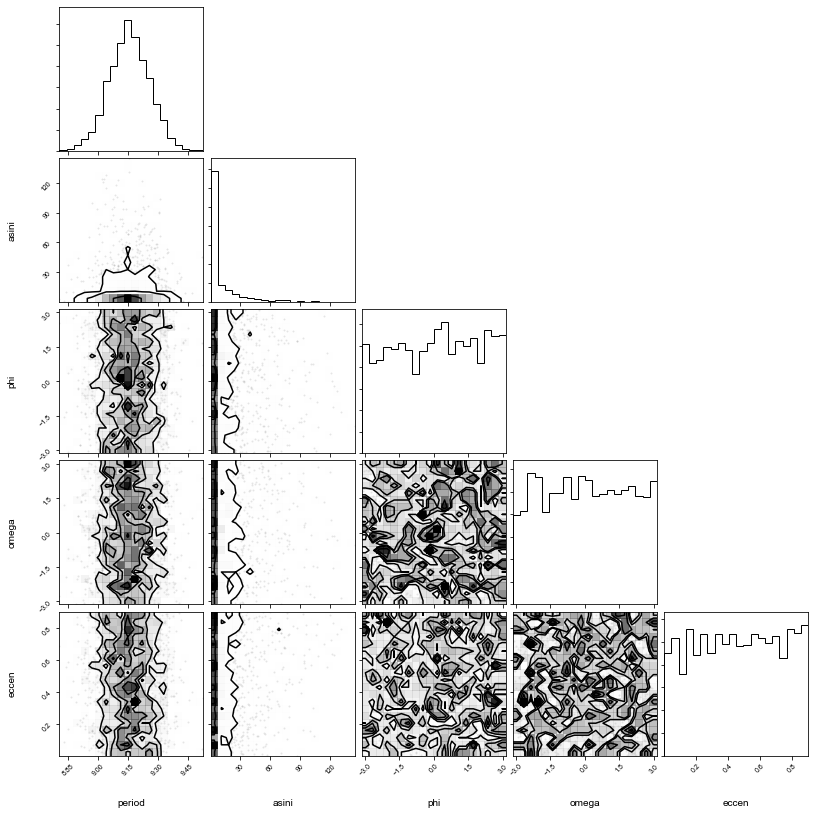

In [18]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['period', 'asini', 'phi', 'omega', 'eccen']));